# Spectrogram Test Notebook

This notebook demonstrates the varies functionalities available within the **pyspch.spectrogram** module

- plotting of waveforms , spectrograms and segmentations
- computation of basic and mel spectrograms (wrappers around libosa)

Date: 07/05/2021 , 12/05/2021

tested with v0.6: 24/03/2022, 19/04/2022   
tested with v0.7: 26/01/2023.  

## First do all the imports


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML, clear_output
from ipywidgets import interact

import math,time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import librosa as librosa
    
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

## 1. Read in audio data and compute spectrograms

In [4]:
# read a datafile
dir='https://homes.esat.kuleuven.be/~spchlab/data/'
file = "timit/audio/train/dr1/fcjf0/si1027" 
file = "misc/friendly"
wavfile = dir+file+".wav" 
wavdata, sr = Spch.audio.load(wavfile)
dt = 1/sr if file.split('/')[0]=='timit' else 1.    # 1/sr for TIMIT files, 1. otherwise

# compute a standard spectrogram and a 80 and 24 channel mel filterbank
spg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
spg80 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=80)
spg24 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=24)

# get segmentations
segwrd = Spch.timit.read_seg_file(dir+file+ ".wrd",dt=dt,fmt='float32')
segphn = Spch.timit.read_seg_file(dir+file+ ".phn",dt=dt,fmt='float32',xlat='timit61_41')

#### (a) Basic Plot
x-axis is displayed on index basis

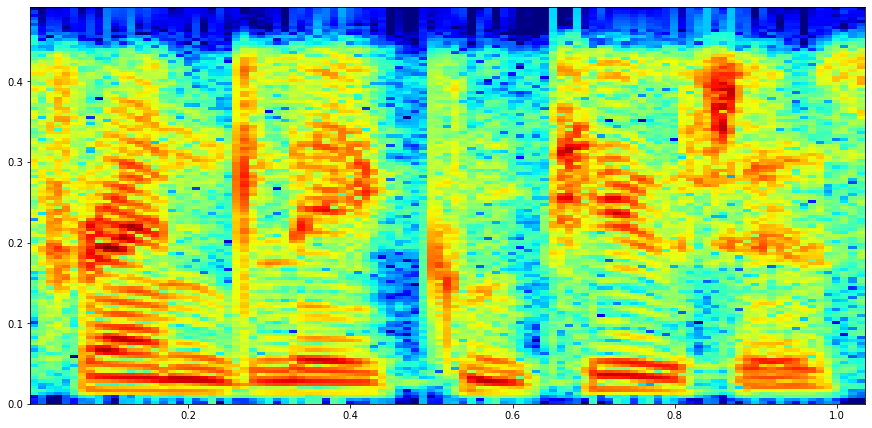

In [6]:
Spd.PlotSpg(spg1)

#### to align time waveform and spectrogram, the plotting routine must know a frame shift in samples (or time)

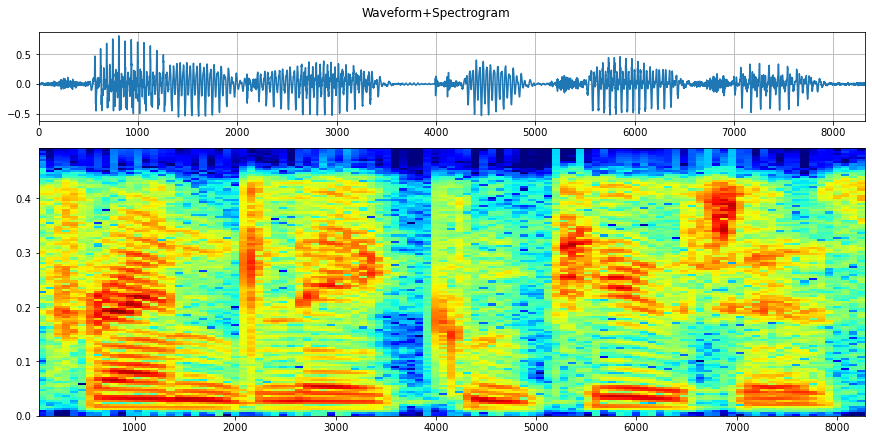

In [7]:
fig=Spd.PlotSpg(spgdata=spg1,wavdata=wavdata,shift=80,title="Waveform+Spectrogram")
display(fig)

#### (b) Basic Plot with Physical Units
- adding sample_rate to the arguments, everything will be displayed using time-units on the x-axis
- ylabel is the label for the frequency axis
- The y-axis is inferred from sampling frequency and number of parameters in spg; it could be overridden with a 'dy' parameter

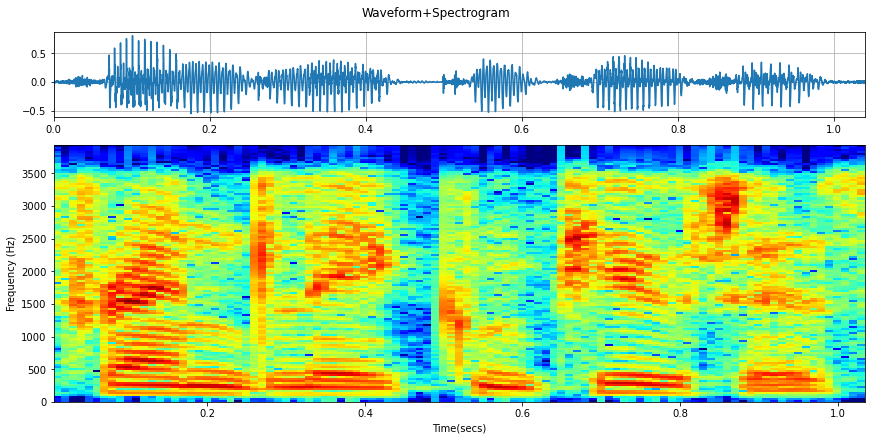

In [8]:
fig=Spd.PlotSpg(spg1,wavdata=wavdata,sample_rate=sr,title="Waveform+Spectrogram",ylabel='Frequency (Hz)')
fig

#### (c) A plot with multiple spectrograms
when adding sample_rate to the arguments, everything will be displayed using time-units on the x-axis

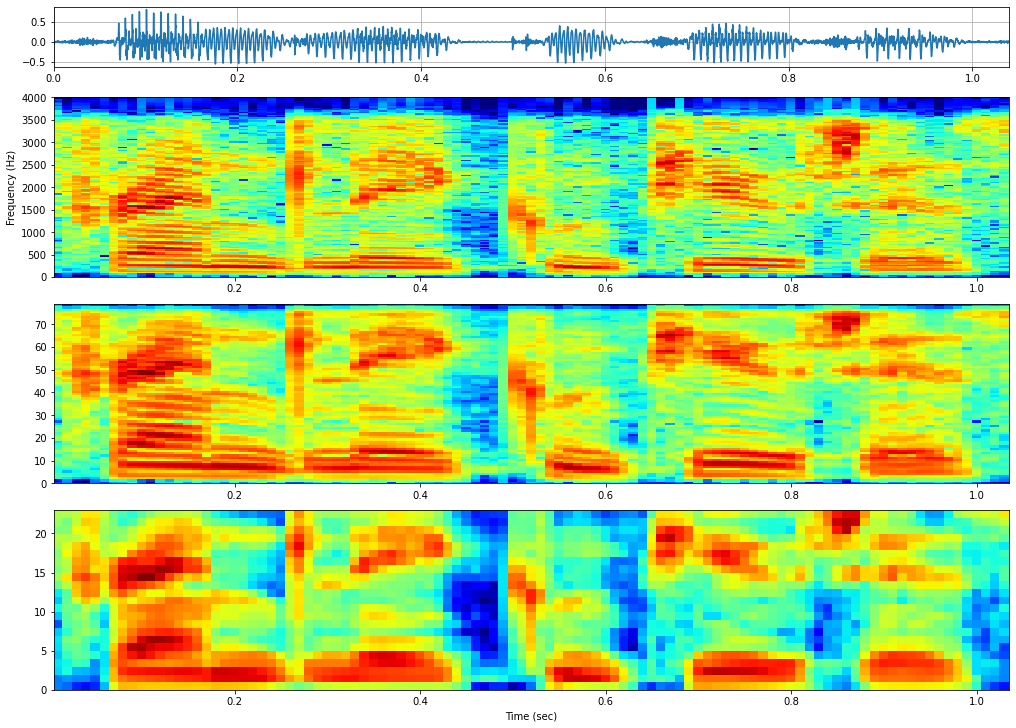

In [9]:
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg1,img_ftrs=[spg80,spg24],sample_rate=sr,figsize=(14,10))

Label details of the img_ftrs or other axis related specification can be added via regular matplotlib calls on the axis

In [ ]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg1,img_ftrs=[spg80,spg24],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_ylabel("Mel 80")
fig.axes[3].set_ylabel("Mel 24")
display(fig)

## 2. Spectrogram Plots overlayed with Segmenations

#### Spectrograms with added segmentations
- a word segmenation is added to the waveform plot
- a phone segmenation is added to the spectrogram plot

In [ ]:
segphn

In [ ]:
fig = Spd.PlotSpg(spg1,wavdata=wavdata,segwav=segphn,segspg=segphn,sample_rate=sr)
display(fig)
display(Audio(data=wavdata,rate=sr))

#### Zooming in with frame selection
- via the parameter frames[] given first and last frame

## Making your own plots with the low level API
- first create the axis, only specifying the respective height ratios
- then add lines, images or segmentations to the individual axis
- remark: 
    + when placing segmentations in an empty box, then the time limits must be passed via xlim
    + when overlaying segmentations in an existing box, the time axis is inherited, though you may need to specify dx= sampling period

In [ ]:
plt.close('all')
def MyPlot(wavdata,sr,spg1,spg2,seg1,seg2,title=None):   
    fig = Spd.SpchFig(figsize=(12,8),row_heights=[1.,2.,2.,1.],dpi=100)
    fig.add_line_plot(wavdata,iax=0,dx=1./sr)
    fig.add_img_plot(spg1,iax=1,xticks=False)
    fig.add_img_plot(spg2,iax=2)
    fig.add_seg_plot(seg1,iax=3,xrange=fig.axes[0].get_xlim(),ypos=0.8,
                     txtargs={'color':'blue','fontsize':14},lineargs={'color':'blue'}) 
    fig.add_seg_plot(seg2,iax=3,ypos=0.2,lineargs={'linestyles':'dotted'})
    fig.suptitle(title,fontsize=16);
    return fig
fig = MyPlot(wavdata,sr,spg1,spg80,segwrd,segphn)
ax=fig.axes
ax[1].set_ylabel('Frequency index')
ax[2].set_ylabel('Mel Band [80]')
fig.align_ylabels(ax[:])
display(fig)
display(Audio(data=wavdata,rate=sr))

## Spectrogram and waveform plot with optional segmentations

In [ ]:
#fig,_ = plot_spg(spg,segspg=segphn39)
fig = Spd.PlotSpg(spg1,wavdata=wavdata,segwav=segwrd,segspg=segphn,frames=[70,100],sample_rate=sr,dpi=200)
display(fig)
display(Audio(data=wavdata,rate=sr))

In [ ]:
waveform = np.vstack((wavdata,wavdata))
fig=Spd.PlotWaveform(waveform[:,0:10000],sr,title="Multichannel Waveform Plot",figsize=(12,4));
display(fig)

## INTERACTIVE FIGURES

#### (a) Reusing the axis for multiple plots in animated/interactive setting

In [ ]:
fig = Spd.PlotSpg(spg1,wavdata=wavdata,sample_rate=sr,title="Waveform+Spectrogram")

display(fig)
time.sleep(1)
Spd.PlotSpg(spg80,fig=fig,wavdata=wavdata,sample_rate=sr,title="Waveform+Spectrogram")
clear_output(wait=True)
display(fig);
time.sleep(1)
Spd.PlotSpg(spg24,fig=fig,wavdata=wavdata,sample_rate=sr,title="Waveform+Spectrogram")
clear_output(wait=True)
display(fig);

## Data with higher sampling rates

In [ ]:
wavfile = "https://homes.esat.kuleuven.be/~compi/demos/AuditoryDemonstrations/"+"TrackNo01.wav"
wavdata, sr = Spch.audio.load(wavfile,sample_rate=16000)
wavdata.shape, sr
# 
spg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
Spd.PlotSpg(spg1,wavdata=wavdata,sample_rate=sr)

In [ ]:
sample_rate=44100
wavdata, sr = Spch.audio.load(wavfile,sample_rate=sample_rate)
wav1 = wavdata[0:(sample_rate*2)]
spg1 = Sps.spectrogram(wav1,sample_rate=sr,n_mels=None)
#Spd.PlotWaveform(wav1)
Spd.PlotSpg(spg1,wavdata=wav1,sample_rate=sr)

In [ ]:
spg1 = Sps.spectrogram(wav1,sample_rate=sr,n_mels=200)
Spd.PlotWaveform(wav1)
Spd.PlotSpg(spg1,sample_rate=sr,dy=30/200)